<h1> Importing libraries </h1>

# New Section

In [1]:
import json
import math
import pandas as pd
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools
import mlflow

In [2]:
import dagshub
dagshub.init(repo_owner='VivekMaltare',repo_name='Skin-Cancer-Prediction')

Initialized MLflow to track repo "VivekMaltare/Skin-Cancer-Prediction"

Repository VivekMaltare/Skin-Cancer-Prediction initialized!

In [3]:
remote_server_uri="https://dagshub.com/VivekMaltare/Skin-Cancer-Prediction.mlflow"
mlflow.set_tracking_uri(remote_server_uri)

In [4]:
mlflow.start_run()

<ActiveRun: >

In [3]:
!dir

 Volume in drive D is New Volume
 Volume Serial Number is 4A1D-D440

 Directory of d:\SPE_MAJOR

04/27/2024  06:18 PM    <DIR>          .
04/27/2024  06:18 PM    <DIR>          ..
04/27/2024  04:58 PM             3,306 .gitignore
04/27/2024  06:18 PM    <DIR>          confusion_matrices
04/27/2024  06:14 PM               176 history.json
04/27/2024  04:58 PM             1,090 LICENSE
04/27/2024  07:12 PM    <DIR>          mlruns
04/27/2024  07:12 PM               510 README.md
04/27/2024  07:12 PM         1,594,896 Skin_cancer_prediction.ipynb
04/27/2024  06:00 PM       220,897,135 vgg16_1.keras
               6 File(s)    222,497,113 bytes
               4 Dir(s)  213,840,777,216 bytes free


<h1> Importing data </h1>

In [5]:
import cv2
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

# Define base directory
DIR = r'C:\Users\LENOVO\Downloads\dataset_skin_cancer'

def read_in_rgb(imagename):
    return np.asarray(Image.open(imagename).convert("RGB"))

def Loading_Data_from(DIR, SIZE=224):
    IMG = []

    for u in tqdm(os.listdir(DIR)):
        filetype = u[-4:]
        Path_of_Image = os.path.join(DIR, u)
        if filetype == ".jpg":
            image = read_in_rgb(Path_of_Image)
            image = cv2.resize(image, (SIZE, SIZE))
            IMG.append(np.array(image))

    return IMG

# Construct specific paths
DIR_train_benign = os.path.join(DIR, 'data/train/benign')
DIR_train_malignant = os.path.join(DIR, 'data/train/malignant')
DIR_test_benign = os.path.join(DIR, 'test/benign')
DIR_test_malignant = os.path.join(DIR, 'test/malignant')

# Load data
b_train = np.array(Loading_Data_from(DIR_train_benign))
m_train = np.array(Loading_Data_from(DIR_train_malignant))
b_test = np.array(Loading_Data_from(DIR_test_benign))
m_test = np.array(Loading_Data_from(DIR_test_malignant))

100%|██████████| 300/300 [00:00<00:00, 356.18it/s]


In [6]:
print("Data Type of the first image in b_train:", b_train[0].dtype)
print("Data Type of the first image in m_train:", m_train[0].dtype)

Data Type of the first image in b_train: uint8
Data Type of the first image in m_train: uint8


In [7]:
# Check the length of the loaded arrays
print("Length of b_train:", len(b_train))
print("Length of m_train:", len(m_train))
print("Length of b_test:", len(b_test))
print("Length of m_test:", len(m_test))

Length of b_train: 1440
Length of m_train: 1197
Length of b_test: 360
Length of m_test: 300


<h1> Labelling dataset </h1>


In [8]:
from keras.utils import to_categorical
def return_labelled_data(x,y):
  return np.concatenate((x, y), axis = 0)

b_train_label = np.zeros(len(b_train))
m_train_label = np.ones(len(m_train))
b_test_label = np.zeros(len(b_test))
m_test_label = np.ones(len(m_test))

X_train = return_labelled_data(b_train, m_train)
Y_train = return_labelled_data(b_train_label, m_train_label)
X_test = return_labelled_data(b_test, m_test)
Y_test = return_labelled_data(b_test_label, m_test_label)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

<h3> Split test train

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

<h3> Visualising data

Lets look at some of the dataset images


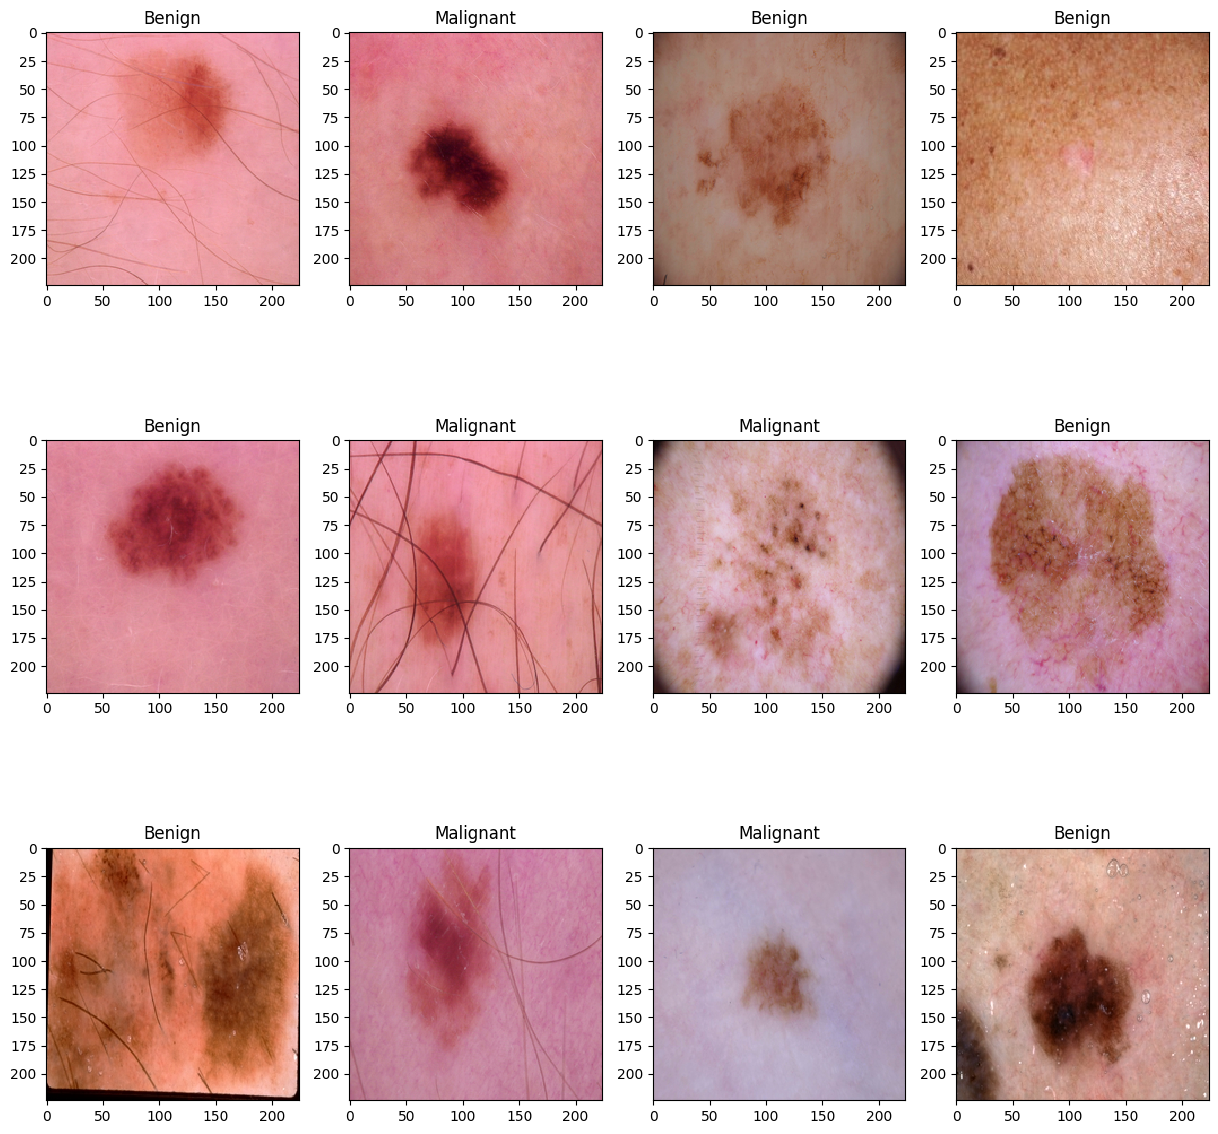

In [10]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15))

print("Lets look at some of the dataset images")
for i in range(1, 12 +1):
    axisi = fig.add_subplot(3, 4, i)
    if np.argmax(Y_train[i]) == 0:
        axisi.title.set_text('Benign')
    else:
        axisi.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
# Define the parameters of the ImageDataGenerator
params = {
    'zoom_range': 2,
    'rotation_range': 90,
    'horizontal_flip': True,
    'vertical_flip': True
}

# Log the parameters in MLflow
mlflow.log_params(params)

<h2> Bulding our Model

In [12]:
from keras import layers
from keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def building_model(backbone, learning_rate=1e-3):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = building_model(resnet ,learning_rate = 1e-3)

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ ?                      │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [14]:
# Extract learning rate and optimizer parameters
learning_rate = 1e-3
optimizer = 'Adam'

# Log learning rate and optimizer in MLflow
mlflow.log_param('learning_rate', learning_rate)
mlflow.log_param('optimizer', optimizer)
mlflow.log_param('BATCH_SIZE', BATCH_SIZE)
mlflow.log_param('epochs', 1)

1

In [15]:
# Calculate the steps_per_epoch as an integer
steps_per_epoch = math.ceil(x_train.shape[0] / BATCH_SIZE)

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="vgg16_1.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=steps_per_epoch,
    epochs=1,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7163 - loss: 0.6102
Epoch 1: val_accuracy improved from -inf to 0.68182, saving model to vgg16_1.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 1562s 10s/step - accuracy: 0.7165 - loss: 0.6099 - val_accuracy: 0.6818 - val_loss: 46.4969 - learning_rate: 0.0010


In [16]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

In [17]:
Y_val_pred = model.predict(x_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate evaluation metrics
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(Y_val_pred, axis=1)
accuracy = accuracy_score(y_val_true, y_val_pred)
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')
roc_auc = roc_auc_score(y_val_true, y_val_pred)

# Log the evaluation metrics in MLflow
mlflow.log_metric('accuracy', accuracy)
mlflow.log_metric('precision', precision)
mlflow.log_metric('recall', recall)
mlflow.log_metric('f1_score', f1)
mlflow.log_metric('roc_auc_score', roc_auc)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')


Accuracy: 0.6818
Precision: 0.7147
Recall: 0.6818
F1 Score: 0.6570
ROC AUC Score: 0.6587


In [19]:
mlflow.log_artifact('history.json')

In [20]:
Y_pred = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step


In [21]:
# Calculate evaluation metrics
y_test_true = np.argmax(Y_test, axis=1)
y_test_pred = np.argmax(Y_pred, axis=1)
accuracy_test = accuracy_score(y_test_true, y_test_pred)
precision_test = precision_score(y_test_true, y_test_pred, average='weighted')
recall_test = recall_score(y_test_true, y_test_pred, average='weighted')
f1_test = f1_score(y_test_true, y_test_pred, average='weighted')
roc_auc_test = roc_auc_score(y_test_true, y_test_pred)

# Log the evaluation metrics in MLflow
mlflow.log_metric('accuracy_test', accuracy_test)
mlflow.log_metric('precision_test', precision_test)
mlflow.log_metric('recall_test', recall_test)
mlflow.log_metric('f1_score_test', f1_test)
mlflow.log_metric('roc_auc_score_test', roc_auc_test)

# Print the evaluation metrics
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC Score: {roc_auc_test:.4f}')

Test Accuracy: 0.6742
Test Precision: 0.6981
Test Recall: 0.6742
Test F1 Score: 0.6521
Test ROC AUC Score: 0.6525


Confusion matrix, without normalization
[[321  39]
 [176 124]]


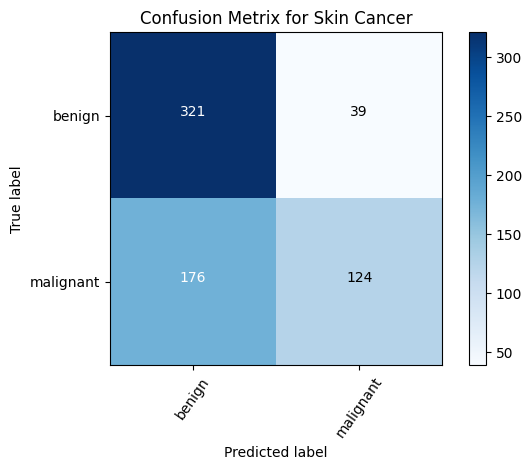

In [22]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [23]:
# Generate the confusion matrix plot
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
cm_plot_label = ['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title='Confusion Matrix for Skin Cancer')

# Log the confusion matrix plot as an artifact
output_dir = "confusion_matrices"
os.makedirs(output_dir, exist_ok=True)  # Create a directory to save the confusion matrix
cm_filename = "confusion_matrix2.png"  # Name of the confusion matrix file
plt.savefig(os.path.join(output_dir, cm_filename))  # Save the plot to a file

# Close the plot to release memory
plt.close()

# Log the confusion matrix plot as an artifact with MLflow
mlflow.log_artifact(os.path.join(output_dir, cm_filename), artifact_path="confusion_matrices")


Confusion matrix, without normalization
[[321  39]
 [176 124]]


In [24]:
#creating a signature to log the model and then logging the model

from mlflow.models import ModelSignature
from mlflow.types.schema import Schema, TensorSpec

# Define the input tensor specification for the image
input_tensor_spec = TensorSpec(np.dtype('uint8'), (-1, 224, 224, 3), "input_image")

# Define the output tensor specification for the predicted class
output_tensor_spec = TensorSpec(np.dtype('str'), (), "predicted_class")

# Create Schema objects for inputs and outputs
input_schema = Schema([input_tensor_spec])
output_schema = Schema([output_tensor_spec])

# Create a ModelSignature instance
model_signature = ModelSignature(inputs=input_schema, outputs=output_schema)

# Log the model with the input signature
#mlflow.keras.log_model(model, "models", signature=model_signature)


In [25]:
# # Assuming the model is already logged under a specific run ID
# run_id = "af14d663713643e9af080770c555841b"

# # Construct the model URI including the "models" folder
# model_uri = f"file:///d:/SPE_MAJOR/mlruns/0/{run_id}/artifacts/models"

# # Register the model to the MLflow registry
# registered_model_name = "first registered model"
# mlflow.register_model(model_uri, registered_model_name)

from urllib.parse import urlparse

tracking_url_type_store=urlparse(mlflow.get_tracking_uri()).scheme

print(tracking_url_type_store)
if(tracking_url_type_store!="file"):
    mlflow.keras.log_model(model,"models",registered_model_name="Skin Cancer Prediction",signature=model_signature)
else:
    mlflow.keras.log_model(model,"models",signature=model_signature)
  

https


2024/04/28 11:40:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\LENOVO\AppData\Local\Temp\tmpsty1f47l\model, flavor: keras). Fall back to return ['keras==3.2.1']. Set logging level to DEBUG to see the full traceback. 
C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'Skin Cancer Prediction'.
2024/04/28 11:41:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Skin Cancer Prediction, version 1
Created version '1' of model 'Skin Cancer Prediction'.
